In [1]:
import torch.nn as nn
import torch
import numpy as np

from matplotlib import pyplot as plt
from torch.optim import Adam

# Deep O Net Tutorial

This notebook gives a brief introduction to DeepOnets by Lu et al in their paper found [here](https://arxiv.org/abs/1910.03193). Here we aim to create an Operator network that can solve the following similar 1D ODE problem given in the paper:
$$
\frac{d}{dx}F(x) = g(x) \\
F(0) = 0\\
for \  x \in [0,2]
$$

Where $g(x)$ is given. This is essentially integration of a 1D function with the initial condition $F(0) = 0$. In practice, the operator mapping can be fairly arbitary e.g. initial states, boundary conditions, partial data, etc.

We look at 2 different approaches: Data Driven and physics informed. Data Driven has faster convergence and is more straight forward but requires data which may not neccesarily be available for more complicated Operators. Physics informed does not need any data (other than $F(0) = 0$ and the equations governing the Operator) but is slower to train

Like regular deep learning tasks such as image classification or NLP, sampling too far out of training distribution (i.e. a $g(x)$ too wildly different from the given dataset) will cause the operator network to fail to produce the correct results.

## Network

The network $G(u)(y)$ takes in two inputs: y and u. here 'u' represents the $g(x)$ in our problem. Because of the structure of networks, we have to discretize the function $g$ at a fixed number of grid points. We'll use 100 uniformly spread points across the range 0 to 2. Note that the location of each sensor $u(x_i)$ is implicitly given (i.e. we don't tell the network this info but it is baked via our training samples) and remains fixed for all $g) 

Here 'y' represents the points we want to query. Because $g(x)$ takes the range (0,2), any y points we specify will also need to take the range (0,2).

The Deep O Net uses a the stacked net from Lu et al. Essentially this is two seperate networks called the branch and trunk network that each handle the input function and sampling point respectively. They are merged at some latent representation through element wise multiplication and then passed through a final linear layer.



For both the trunk and branch net, we'll just use the standard MLP networks with tanh activations.

The number of sensors for $u(x)$ can be different to the number of points we sample for i.e. the input shapes to the trunk and branch net can be different. This means we need 2 'batch' dimensions to loop over - one to handle the trunk net and one for the branch net. Base on how `nn.Linear` works we define the inputs to the Onet as:

- branch net $u(x)$ has shape [B,1,M]
- trunk net input has shape [B,N,I]
- Output of Onet shape [B,N,O]

Where:
- B is the batch dimension for the branch net
- N is the 'batch' dimension for the trunk net
- M is the number of sensors that discretize u(x)/input dimension of the branch net
- I is the input dimension of the trunk net
- O is the output dimension size of the Onet

For this example:
$$
B = 10,000\\
N = 100\\
M = 100\\
I = 1\\
O = 1\\
$$

In [2]:
class MLP(nn.Module):
    def __init__(self,in_features : int,out_features: int,hidden_features: int,num_hidden_layers: int) -> None:
        super().__init__()

        
        self.linear_in = nn.Linear(in_features,hidden_features)
        self.linear_out = nn.Linear(hidden_features,out_features)
        
        self.activation = torch.tanh
        self.layers = nn.ModuleList([self.linear_in] + [nn.Linear(hidden_features, hidden_features) for _ in range(num_hidden_layers)  ])
        
         
    def forward(self,x):
        for layer in self.layers:
            x = self.activation(layer(x))
    
        return self.linear_out(x)


class DeepONet(nn.Module):
    def __init__(self,latent_features,out_features,branch,trunk) -> None:
        super().__init__()
        self.branch = branch
        self.trunk = trunk
        self.fc = nn.Linear(latent_features,out_features,bias = False)
        

    def forward(self,y,u):
        return self.fc(self.trunk(y)*self.branch(u))

In [3]:
Onet = DeepONet(75,1,branch = MLP(100,75,75,4),trunk = MLP(1,75,75,4))

u = torch.rand((2,1,100))
y = torch.rand((2,40,1))

xx =Onet.trunk(y)
tt = Onet.branch(u)

Onet(y,u).shape

torch.Size([2, 40, 1])

# Generating Data

We'll generate our derivatives $u(x)$ using Chebyshev polynomials. There's many different ways of generating random smooth functions but well use this way.

We use a mix of numpy and scipy integration to get the derivative and the integral function at each point. We then discretize both functions. for the derivative $u(x)$ we discretize using 100 uniformly spaced points. for $G(u)(y)$ we randomly sample $N = 100$ points in the domain

The tuple of data of the shape (y,u,Guy) where:
- y is the sampling points of shape $[10000,100,1]$
- u is the discretized derivative function of shape $[10000,1,100]$
- $G(u)(y)$ is target output of the Onet os shape $[10000,100,1]$

In [4]:
from numpy.polynomial.chebyshev import Chebyshev,chebval,chebint,cheb2poly
def random_chebyshev(n,M,degree,return_coeff = False):
    '''
    This generates a random function output between the domain [-1,1] along a uniform grid of size n using chebyshev polynomials.
    '''
    coeff = (np.random.rand(degree+1)-0.5)*2*np.abs(M)
    x= np.linspace(-1,1,n)
    y = chebval(x,coeff)
    if return_coeff:
        return x,y,coeff
    else:
        return x,y



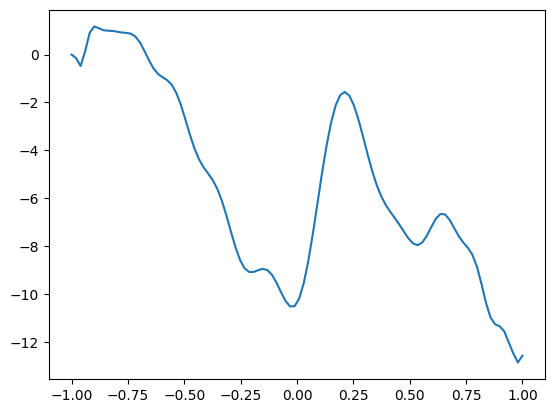

In [5]:
from scipy.integrate import cumulative_trapezoid
x,y,coeff = random_chebyshev(100,10,30,return_coeff= True)

y_int = cumulative_trapezoid(y,x,initial = 0)

plt.plot(x,y_int)



In [6]:
# Generate DataTuples:
def generate_data(n_samples,a,b,n_sensors,n_points,M,degree,y0 = 0,random_query = False,seed = 1234):
    '''
    Generate Data needed for training.

    Returns a tuple of (y,u,Guy) that will be added to the Dataloader
    '''
    if seed is not None:
        np.random.seed(1234)
    
    x = np.linspace(-1,1,n_points)
    u,dy_coeff = zip(*[random_chebyshev(n_sensors,M,degree,return_coeff=True)[1:] for _ in range(n_samples)])

    u = np.stack(u,axis = 0)

    #Generate 100 y points for -1 and 1
    
    xp = np.linspace(a,b,n_sensors)
    if random_query:
        y = np.random.rand(n_samples,n_points)*(b-a)+a
    else:
        # y = np.array([np.linspace(a,b,n_points) for _ in range(n_samples)]
        y = np.tile(np.linspace(a,b,n_points),(n_samples,1))

    #Integrate cheb poly, we use interp in case we want random y points
    Guy = [cumulative_trapezoid(dy,xp,initial=y0) for dy in u]
    Guy = [np.interp(yy,xp,G) for yy,G in zip(y,Guy)]

    #Guy data needs 2 batch dimensions: One for samples and the other for  
    y,u,Guy = torch.tensor(y,dtype = torch.float32),torch.tensor(u,dtype = torch.float32),torch.tensor(Guy,dtype = torch.float32)
    #To match network shape input and output, need to add a tensor dimension to y and Guy
    return y.unsqueeze(-1),u.unsqueeze(1),Guy.unsqueeze(-1)

In [7]:
ys,us,Guys = generate_data(100,0,2,100,100,5,20)
ys.shape,us.shape,Guys.shape

C:\Users\John Su\AppData\Local\Temp\ipykernel_21660\4220568694.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  y,u,Guy = torch.tensor(y,dtype = torch.float32),torch.tensor(u,dtype = torch.float32),torch.tensor(Guy,dtype = torch.float32)


(torch.Size([100, 100, 1]),
 torch.Size([100, 1, 100]),
 torch.Size([100, 100, 1]))

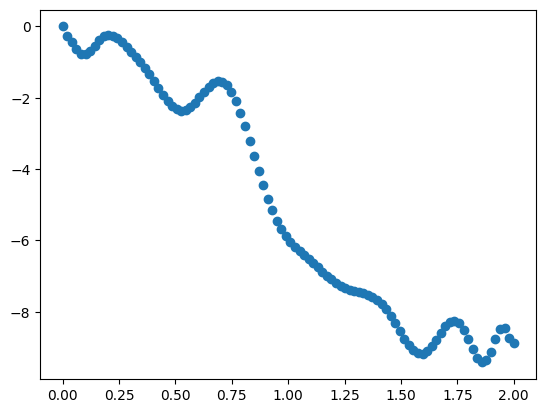

In [8]:
x = np.linspace(0,2,100)

plt.scatter(ys[2].squeeze(),Guys[2].squeeze())

# Training Pipeline

We can then create a very straight forward training pipeline to train our data driven Onet. This is identical to other training pipelines such as image classification and we can simply use a dataloader

In [9]:
from torch.utils.data import DataLoader,Dataset

In [10]:
class Onet_dataset(Dataset):
    def __init__(self,y,u,Guy):
        self.y = y
        self.u = u
        self.Guy = Guy
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.y[idx],self.u[idx],self.Guy[idx]

In [11]:
ys,us,Guys = generate_data(10000,0,2,100,90,5,20)
Onet_data = Onet_dataset(ys,us,Guys)
# Onet_data.set_device('cuda')
Onet_DL = DataLoader(Onet_data,batch_size = 1000,shuffle = True)

Onet = DeepONet(75,1,branch = MLP(100,75,75,4),trunk = MLP(1,75,75,4))


optimiser = Adam(Onet.parameters(),lr = 5e-4)
lr_sch = torch.optim.lr_scheduler.StepLR(optimiser,1000,0.95)


In [12]:
Onet = Onet.cuda()
optimiser.zero_grad()
x = torch.linspace(0,2,100)
a = 4
dy = torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
print(dy_in.shape,x_in.shape)

loss_list = []
acc_list = []
for epoch in range(0,7501):
    for (y,u,Guy) in(Onet_DL):
        (y,u,Guy) = (y.cuda(),u.cuda(),Guy.cuda())
        # print(y.shape,u.shape,Guy.shape)
        out = Onet(y,u)
        # print(out.shape,Guy.shape)
        loss = (out-Guy).pow(2).mean()
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        lr_sch.step()
    if (epoch % 100) == 0:
        print(f'{float(lr_sch.get_last_lr()[0]):.3E}')
        with torch.no_grad():
            out = Onet.cpu()(x_in,dy_in).squeeze()
            accuracy = (out-out_true).pow(2).mean()
            Onet = Onet.cuda()
        
        print(f'Epoch: {epoch} loss {float(loss):.3e} Acc {float(accuracy):.3e}')
        loss_list.append(float(loss))
        acc_list.append(float(accuracy))

        


torch.Size([1, 1, 100]) torch.Size([1, 100, 1])
5.000E-04
Epoch: 0 loss 1.506e+01 Acc 8.003e-02
4.750E-04
Epoch: 100 loss 5.660e-01 Acc 2.994e-01
4.512E-04
Epoch: 200 loss 2.751e-01 Acc 2.031e-02
4.287E-04
Epoch: 300 loss 1.941e-01 Acc 3.311e-03
4.073E-04
Epoch: 400 loss 1.455e-01 Acc 2.094e-03
3.869E-04
Epoch: 500 loss 1.188e-01 Acc 9.855e-04
3.675E-04
Epoch: 600 loss 8.870e-02 Acc 1.278e-03
3.492E-04
Epoch: 700 loss 7.853e-02 Acc 2.534e-04
3.317E-04
Epoch: 800 loss 6.071e-02 Acc 2.991e-04
3.151E-04
Epoch: 900 loss 6.048e-02 Acc 1.859e-04
2.994E-04
Epoch: 1000 loss 4.914e-02 Acc 3.782e-04
2.844E-04
Epoch: 1100 loss 4.434e-02 Acc 3.496e-04
2.702E-04
Epoch: 1200 loss 3.429e-02 Acc 2.309e-04
2.567E-04
Epoch: 1300 loss 3.131e-02 Acc 1.600e-04
2.438E-04
Epoch: 1400 loss 3.310e-02 Acc 2.067e-04
2.316E-04
Epoch: 1500 loss 2.929e-02 Acc 1.853e-04
2.201E-04
Epoch: 1600 loss 2.058e-02 Acc 2.415e-04
2.091E-04
Epoch: 1700 loss 1.984e-02 Acc 1.229e-04
1.986E-04
Epoch: 1800 loss 1.975e-02 Acc 3.213

torch.Size([100])


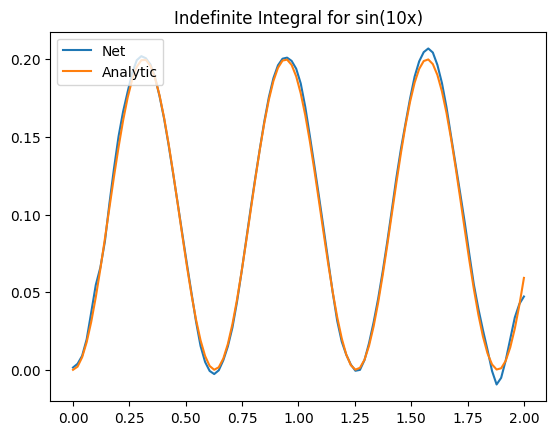

In [227]:
a = 10

x = torch.linspace(0,2,100)
dy = torch.sin(a*x)
dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
-(torch.cos(a*x)-1)
with torch.no_grad():
    out = Onet.cpu()(x_in,dy_in).squeeze()

print(out.shape)

plt.plot(x,out,label = 'Net')
plt.plot(x,out_true,label = 'Analytic')
plt.legend(loc='upper left')
plt.title(f'Indefinite Integral for sin({a}x)')
plt.savefig(f'a_{a}.png')
plt.show()

# Physics Informed Deep O Net

We can also use physics informed training to train our Onet. In this example, we only use the derivative information and the initial condition $F(0)=0$ to train our network. No other data is used. For this example, we set the sampling point y to be the same as the points used to discretize $u(x)$ for convience.

This process takes longer and doesn't make too much sense for this example. But we can imagine problems where the sensors are sparse (e.g. only at the boundaries of domains) and therefore PINNs can be a good way to enforce laws at locations far from sensors.

To take derivatives efficiently, we use the `torch.func` library a jax like library designed for pytorch. We only want the derivatives of the output wrt to the sampling points y and not u(x). We use `vmap` to iterate over the 2 batch dimensions to achieve this and `jacrev` to calculate the derivatives.

Training takes quite a bit longer and is less stable but we require significantly less data/information about the Operator.

In [13]:
from torch.func import vmap,jacrev,grad

In [14]:
def batched_PINO_grad(net):
    def aux_net(net):
        def inner_func(*args,**kwargs):
            out = net(*args,**kwargs)
            return out,out
        return inner_func
    
    g = jacrev(aux_net(net),has_aux=True)
    # If y,u are the arg inputs, we only want to iterate over y's first dim (the query dim) not u

    grad_func = vmap(g,(0,None))

    return vmap(grad_func,0)
    



In [15]:

PINO = DeepONet(75,1,branch = MLP(100,75,75,4),trunk = MLP(1,75,75,4))

f = batched_PINO_grad(PINO)
y = torch.rand((5,100,1))
u = torch.rand((5,1,100))

grads,evals = f(y,u)
grads.shape,evals.shape,PINO(y,u).shape

(torch.Size([5, 100, 1, 1, 1]),
 torch.Size([5, 100, 1, 1]),
 torch.Size([5, 100, 1]))

In [16]:
ys,us,Guys = generate_data(10000,0,2,100,100,5,20)
Pino_data = Onet_dataset(ys,us,Guys)
# Onet_data.set_device('cuda')
Pino_DL = DataLoader(Pino_data,batch_size = 1000,shuffle = True)


optimiser = Adam(PINO.parameters())
lr_sch = torch.optim.lr_scheduler.StepLR(optimiser,1000,0.95)

In [17]:
evals[:,0].squeeze()

tensor([-0.0011, -0.0021, -0.0012, -0.0023, -0.0019],
       grad_fn=<SqueezeBackward0>)

In [18]:
PINO = PINO.cuda()
optimiser.zero_grad()
x = torch.linspace(0,2,100)
a = 4
dy = torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
print(dy_in.shape,x_in.shape)

PINO_loss_list= []
PINO_acc_list = []
f = batched_PINO_grad(PINO)
for epoch in range(0,7501):
    for (y,u,Guy) in(Pino_DL):
        (y,u,Guy) = (y.cuda(),u.cuda(),Guy.cuda())
        # print(y.shape,u.shape,Guy.shape)
        grads,evals = f(y,u)

        #PINN loss
        
        PINN_loss = (grads.squeeze() - u.squeeze()).pow(2).mean()
        
        #Initial Condition Loss
        IC_loss = (evals[:,0].squeeze()).pow(2).mean()

        # print(out.shape,Guy.shape)
        # loss = (out-Guy).pow(2).mean()
        loss = 10*PINN_loss + IC_loss
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        lr_sch.step()
    if (epoch % 100) == 0:
        print(f'{float(lr_sch.get_last_lr()[0]):.3E}')
        with torch.no_grad():
            out = PINO.cpu()(x_in,dy_in).squeeze()
            accuracy = (out-out_true).pow(2).mean()
            PINO = PINO.cuda()
        
        print(f'Epoch: {epoch} loss {float(loss):.3e} PINN Loss {float(PINN_loss):.3e} IC Loss {float(IC_loss):.3e} Acc {float(accuracy):.3e}')
        PINO_loss_list.append(float(loss))
        PINO_acc_list.append(float(accuracy))
        


torch.Size([1, 1, 100]) torch.Size([1, 100, 1])
1.000E-03
Epoch: 0 loss 8.890e+02 PINN Loss 8.889e+01 IC Loss 4.655e-02 Acc 6.785e-02
9.500E-04
Epoch: 100 loss 9.339e+01 PINN Loss 9.309e+00 IC Loss 3.034e-01 Acc 2.658e-03
9.025E-04
Epoch: 200 loss 1.248e+01 PINN Loss 1.248e+00 IC Loss 9.061e-03 Acc 4.336e-03
8.574E-04
Epoch: 300 loss 1.253e+00 PINN Loss 1.253e-01 IC Loss 1.429e-04 Acc 9.300e-04
8.145E-04
Epoch: 400 loss 1.208e+00 PINN Loss 1.207e-01 IC Loss 2.930e-04 Acc 1.647e-03
7.738E-04
Epoch: 500 loss 9.204e-01 PINN Loss 9.201e-02 IC Loss 3.101e-04 Acc 6.243e-04
7.351E-04
Epoch: 600 loss 8.648e-01 PINN Loss 8.646e-02 IC Loss 2.290e-04 Acc 9.996e-04
6.983E-04
Epoch: 700 loss 2.137e+01 PINN Loss 2.136e+00 IC Loss 4.584e-03 Acc 6.008e-03
6.634E-04
Epoch: 800 loss 3.430e+00 PINN Loss 3.429e-01 IC Loss 8.697e-04 Acc 1.090e-03
6.302E-04
Epoch: 900 loss 9.164e-01 PINN Loss 9.160e-02 IC Loss 3.800e-04 Acc 6.921e-04
5.987E-04
Epoch: 1000 loss 8.310e-01 PINN Loss 8.309e-02 IC Loss 1.035e-04

torch.Size([100])


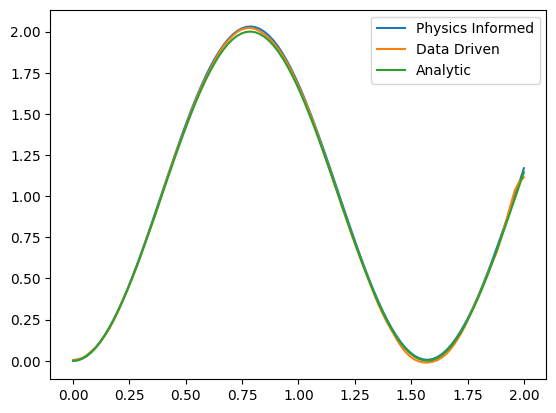

In [ ]:
x = torch.linspace(0,2,100)
a = 12
dy = a*torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
with torch.no_grad():
    out = PINO.cpu()(x_in,dy_in).squeeze()
    out_dd = Onet.cpu()(x_in,dy_in).squeeze()
print(out.shape)
# out = torch.tensor(out).squeeze()
plt.plot(x,out,label = 'Physics Informed')
plt.plot(x,out_dd,label = 'Data Driven')
plt.plot(x,-(torch.cos(a*x)-1),label = 'Analytic')
plt.legend()

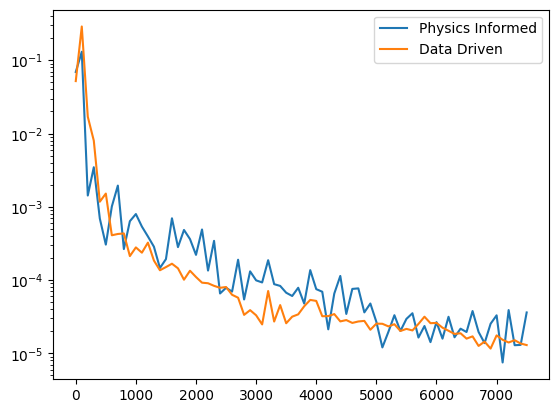

In [166]:
x = np.linspace(0,7500,76)

plt.plot(x,PINO_acc_list,label = 'Physics Informed')
plt.plot(x,acc_list,label = 'Data Driven')
plt.yscale('log')
plt.legend()
plt.title()

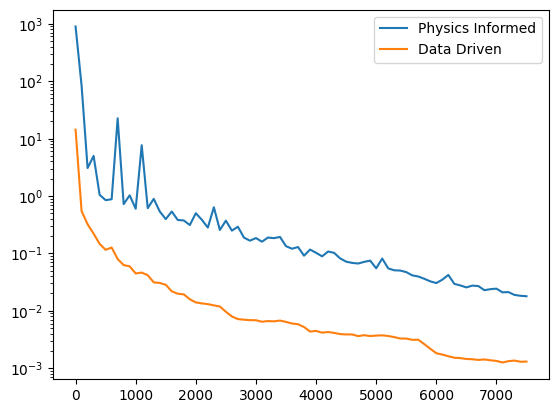

In [167]:
x = np.linspace(0,7500,76)

plt.plot(x,PINO_loss_list,label = 'Physics Informed')
plt.plot(x,loss_list,label = 'Data Driven')
plt.yscale('log')
plt.legend()

torch.Size([100])


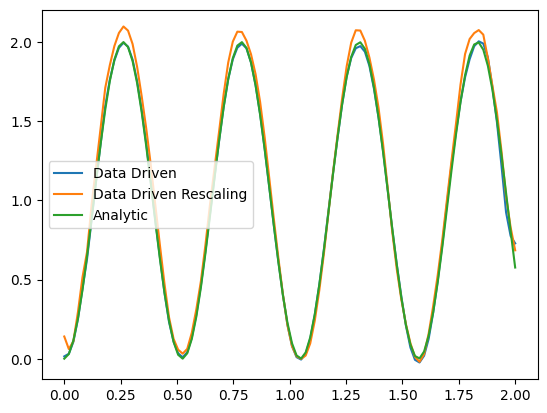

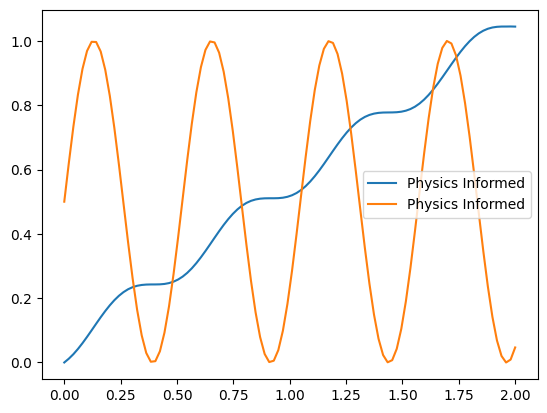

In [198]:
a,b = 0,2

x = torch.linspace(a,b,100)
c = 12
dy = c*torch.sin(c*x)

#Rescale
g = (dy-dy.min())/(dy.max()-dy.min())


dy_in = dy.unsqueeze(0).unsqueeze(1)

g_in = g.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)

# out_true = -1/c*(torch.cos(c*x)-1)
with torch.no_grad():

    G = PINO.cpu()(x_in,g_in).squeeze()
    out = PINO.cpu()(x_in,dy_in).squeeze()
    out_dd = Onet.cpu()(x_in,dy_in).squeeze()
    
    G_dd = Onet.cpu()(x_in,g_in).squeeze()

    dd_rescale = (dy.max()-dy.min())*G_dd + dy.min()*x.squeeze()
    PINO_rescale = (dy.max()-dy.min())*G + dy.min()*x.squeeze()

print(out.shape)
# out = torch.tensor(out).squeeze()
# plt.plot(x,out,label = 'Physics Informed')
# plt.plot(x,PINO_rescale,label = 'Physics Informed Rescaling')
plt.plot(x,out_dd,label = 'Data Driven')
plt.plot(x,dd_rescale,label = 'Data Driven Rescaling')
plt.plot(x,-(torch.cos(c*x)-1),label = 'Analytic')
plt.legend()
plt.show()

plt.plot(x,G,label = 'Physics Informed')
plt.plot(x,g,label = 'Physics Informed')
# plt.plot(x,out_dd,label = 'Data Driven')
# plt.plot(x,,label = 'Analytic')
plt.legend()
plt.show()
